In [20]:
import sys
import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.io import ImportFromTiffTask
from eolearn.ml_tools import TrainTestSplitTask

import os
import glob
import datetime

import rioxarray as rx

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

In [3]:
sentinel_archives_root = '../data/sentinel'
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
sentinel_archives

['../data/sentinel\\S2A_MSIL1C_20210916T170941_N0301_R112_T15TVM_20210916T210302.SAFE',
 '../data/sentinel\\S2A_MSIL1C_20211016T171311_N0301_R112_T15TVM_20211016T191815.SAFE',
 '../data/sentinel\\S2A_MSIL1C_20211125T171641_N0301_R112_T15TVM_20211125T191313.SAFE',
 '../data/sentinel\\S2A_MSIL2A_20211016T171311_N9999_R112_T15TVM_20220417T215507.SAFE',
 '../data/sentinel\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE',
 '../data/sentinel\\S2B_MSIL1C_20211120T171619_N0301_R112_T15TVM_20211120T192246.SAFE',
 '../data/sentinel\\S2B_MSIL1C_20211220T171719_N0301_R112_T15TVM_20211220T192125.SAFE',
 '../data/sentinel\\S2B_MSIL1C_20220119T171629_N0301_R112_T15TVM_20220119T192108.SAFE',
 '../data/sentinel\\S2B_MSIL1C_20220208T171449_N0400_R112_T15TVM_20220208T202020.SAFE',
 '../data/sentinel\\S2B_MSIL1C_20220409T170849_N0400_R112_T15TVM_20220409T202823.SAFE']

In [4]:
l1c_products = eolx.io.get_products_by_level(sentinel_archives, 'L1C')
l1c_products

[(datetime.datetime(2021, 9, 16, 17, 9, 41),
  '../data/sentinel\\S2A_MSIL1C_20210916T170941_N0301_R112_T15TVM_20210916T210302.SAFE'),
 (datetime.datetime(2021, 10, 16, 17, 13, 11),
  '../data/sentinel\\S2A_MSIL1C_20211016T171311_N0301_R112_T15TVM_20211016T191815.SAFE'),
 (datetime.datetime(2021, 11, 20, 17, 16, 19),
  '../data/sentinel\\S2B_MSIL1C_20211120T171619_N0301_R112_T15TVM_20211120T192246.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  '../data/sentinel\\S2A_MSIL1C_20211125T171641_N0301_R112_T15TVM_20211125T191313.SAFE'),
 (datetime.datetime(2021, 12, 20, 17, 17, 19),
  '../data/sentinel\\S2B_MSIL1C_20211220T171719_N0301_R112_T15TVM_20211220T192125.SAFE'),
 (datetime.datetime(2022, 1, 19, 17, 16, 29),
  '../data/sentinel\\S2B_MSIL1C_20220119T171629_N0301_R112_T15TVM_20220119T192108.SAFE'),
 (datetime.datetime(2022, 2, 8, 17, 14, 49),
  '../data/sentinel\\S2B_MSIL1C_20220208T171449_N0400_R112_T15TVM_20220208T202020.SAFE'),
 (datetime.datetime(2022, 4, 9, 17, 8, 49),
  

In [5]:
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 10, 16, 17, 13, 11),
  '../data/sentinel\\S2A_MSIL2A_20211016T171311_N9999_R112_T15TVM_20220417T215507.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  '../data/sentinel\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE')]

In [6]:
import_millie_lacs = ImportFromTiffTask((FeatureType.DATA_TIMELESS, 'bathy_data'), '../data/mille_lacs.tiff')
reproject_bathy = eolx.raster.ReprojectRasterTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

millie_lacs_eop

EOPatch(
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
)

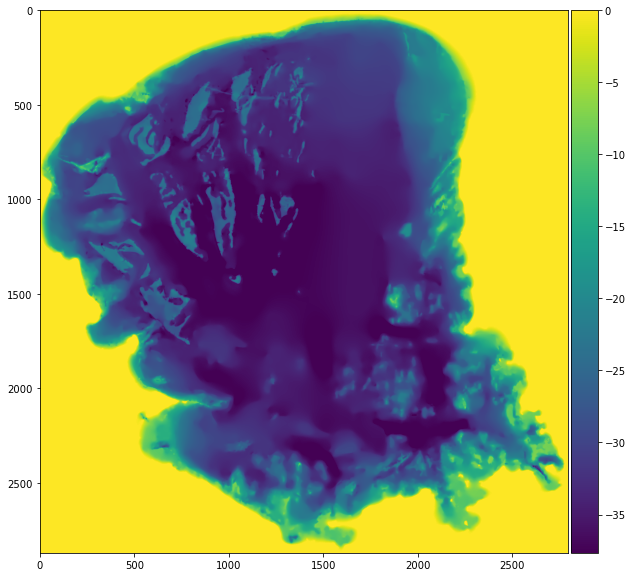

In [7]:
eolx.visualization.plot_single_band(millie_lacs_eop, (FeatureType.DATA_TIMELESS, 'bathy_data'), cmap='viridis')

In [8]:
height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
l2a_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(l2a_products[0][1], target_shape=(height, width), bbox=millie_lacs_eop.bbox)
l2a_eopatch

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 10, 16, 17, 13, 11)]
)

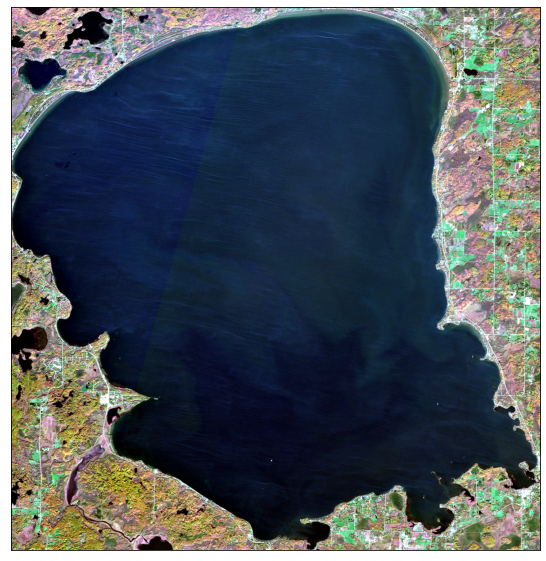

<AxesSubplot:>

In [9]:
eolx.visualization.plot_eopatch(
    l2a_eopatch,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True
)

In [10]:
safe_archive_path = l1c_products[3][1]
height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape
safe_eopatch = eolx.io.construct_eopatch_from_sentinel_archive(safe_archive_path, target_shape=(height, width), bbox=millie_lacs_eop.bbox)
safe_eopatch

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 11, 25, 17, 16, 41)]
)

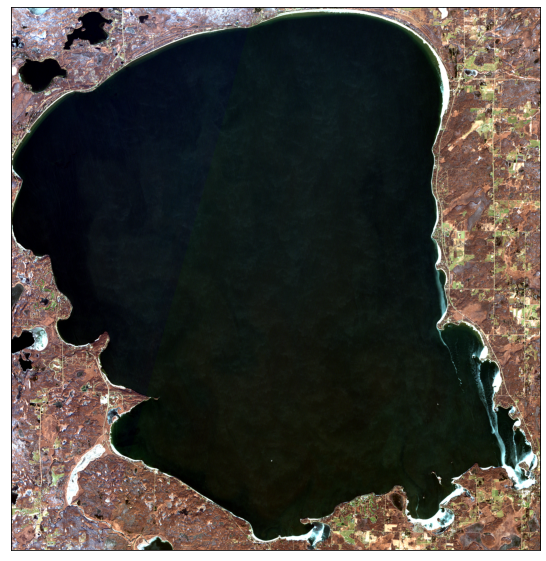

<AxesSubplot:>

In [11]:
eolx.visualization.plot_eopatch(
    safe_eopatch,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L1C_data"),
    stretch=True
)

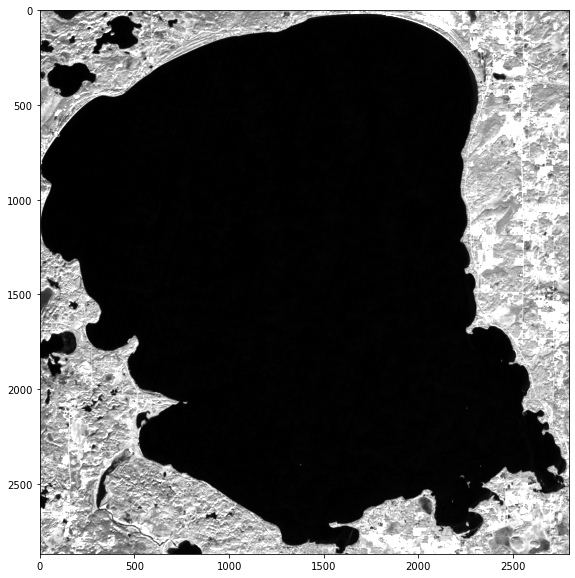

In [12]:
eolx.visualization.plot_single_band(
    safe_eopatch,
    (FeatureType.DATA, "L1C_data"),
    band_index=12,
    time_index=0,
    stretch=True,
    colorbar=False
)

In [19]:
sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_folders


def get_acolite_netcdf_paths(folder, product_type='L2R'):
    nc_pattern = (
        f'{folder}/*_L2R.nc'
        if product_type == 'L2R'
        else f'{folder}/*_L1R.nc'
    )
    ncs = glob.glob(nc_pattern)
    return ncs


path_collections = [get_acolite_netcdf_paths(product_path) for product_path in sentinel_acolite_folders]
flattened_nc_paths = [path for path_collection in path_collections for path in path_collection]
flattened_nc_paths

['../data/sentinel\\S2A_20211125T171641_ACOLITE_SUBSET\\S2A_MSI_2021_11_25_17_20_52_T15TVM_L2R.nc']

In [21]:
rx.open_rasterio(flattened_nc_paths[0])

<xarray.Dataset>
Dimensions:              (y: 3116, x: 3043, band: 1)
Coordinates:
  * y                    (y) float64 5.136e+06 5.136e+06 ... 5.105e+06 5.105e+06
  * x                    (x) float64 4.352e+05 4.352e+05 ... 4.656e+05 4.656e+05
  * band                 (band) int32 1
    transverse_mercator  int32 0
Data variables: (12/26)
    lon                  (band, y, x) float32 ...
    rhos_665             (band, y, x) float32 ...
    rhot_704             (band, y, x) float32 ...
    rhos_704             (band, y, x) float32 ...
    rhot_740             (band, y, x) float32 ...
    rhos_740             (band, y, x) float32 ...
    ...                   ...
    rhos_443             (band, y, x) float32 ...
    rhot_492             (band, y, x) float32 ...
    rhos_492             (band, y, x) float32 ...
    rhot_560             (band, y, x) float32 ...
    rhos_560             (band, y, x) float32 ...
    rhot_665             (band, y, x) float32 ...
Attributes: (12/263)
    10_f0:                                     3671.391743738222
    10_name:                                   1373
    10_wave:                                   1373.462189148828
    11_f0:                                     2456.018139695144
    11_name:                                   1614
    11_wave:                                   1613.659412560426
    ...                                        ...
    wind_default:                              2
    worldview_reproject:                       False
    worldview_reproject_method:                nearest
    worldview_reproject_resolution:            2
    xrange:                                    [435160. 465590.]
    yrange:                                    [5136340. 5105180.]

In [13]:
merge_patches_task = MergeEOPatchesTask()
merged_eop = merge_patches_task.execute(millie_lacs_eop, safe_eopatch, l2a_eopatch)
merged_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
  }
  meta_info={
    mission: 'S2A'
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 11, 25, 17, 16, 41)]
)

In [14]:
data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

input_task = InputTask(merged_eop)
input_node = EONode(input_task, inputs=tuple())

train_test_split_node = EONode(train_test_split_task, inputs=[input_node])
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

train_test_wf = EOWorkflow(
    [
        input_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node
    ]
)

tt_wf_res = train_test_wf.execute(
    input_kwargs={
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = tt_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
  }
  meta_info={
    mission: 'S2A'
    test_count: 1039055
    test_perc: 0.19988842237900803
    train_count: 4159120
    train_perc: 0.8001115776209919
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 11, 25, 17, 16, 41)]
)

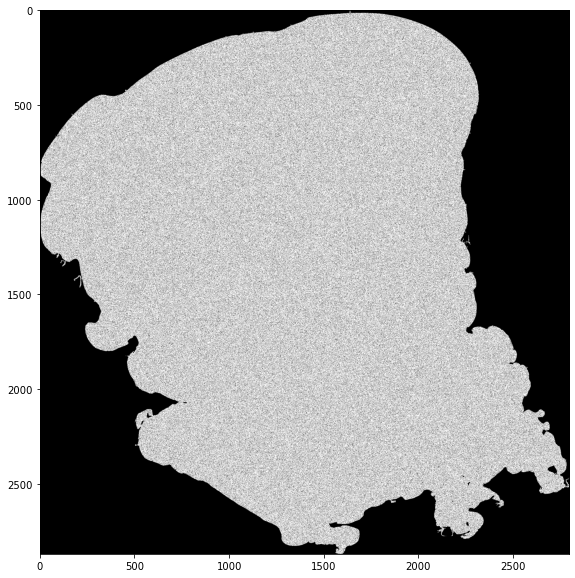

In [15]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False)

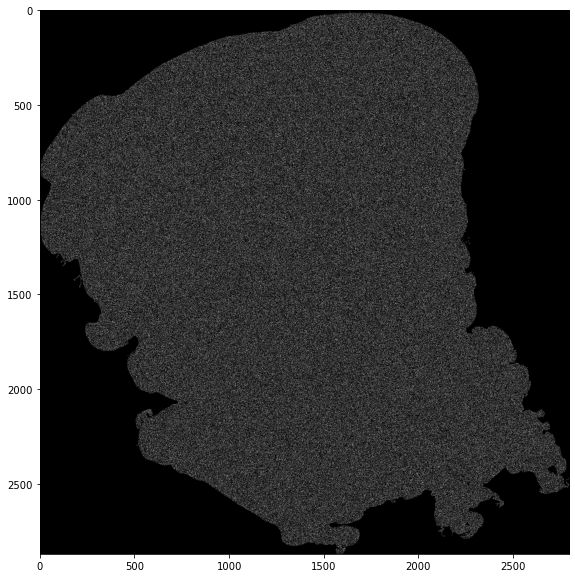

In [16]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'test_split_valid'), colorbar=False)

In [17]:
traincount = train_test_eop.meta_info['train_count']
testcount = train_test_eop.meta_info['test_count']
traincount, testcount

(4159120, 1039055)

### L1C Testing

In [24]:
all_band_train_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], repeats=13, axis=-1)
X = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_train_index == 1], (traincount, 13))
y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 13), (4159120,))

In [25]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-24.097939736774823, 0.03638013299267346)

In [26]:
model = LGBMRegressor()
model.fit(X, y)

LGBMRegressor()

In [27]:
all_band_test_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'test_split_valid')], repeats=13, axis=-1)
X_test = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_test_index == 1], (testcount, 13))
y_test = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'test_split_valid')] == 1]
X_test.shape, y_test.shape

((1039055, 13), (1039055,))

In [28]:
from sklearn.metrics import mean_squared_error

y_hat_test = model.predict(X_test)

-mean_squared_error(y_test, y_hat_test)

-24.07094152294415

In [29]:
bathy_pixels = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)

all_band_index_complete = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], repeats=13, axis=-1)
X_all = np.reshape(train_test_eop[(FeatureType.DATA, 'L1C_data')][0,:,:,:][all_band_index_complete == 1], (bathy_pixels, 13))

y_hat_all = model.predict(X_all)
empty_validation_target = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
empty_validation_target[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

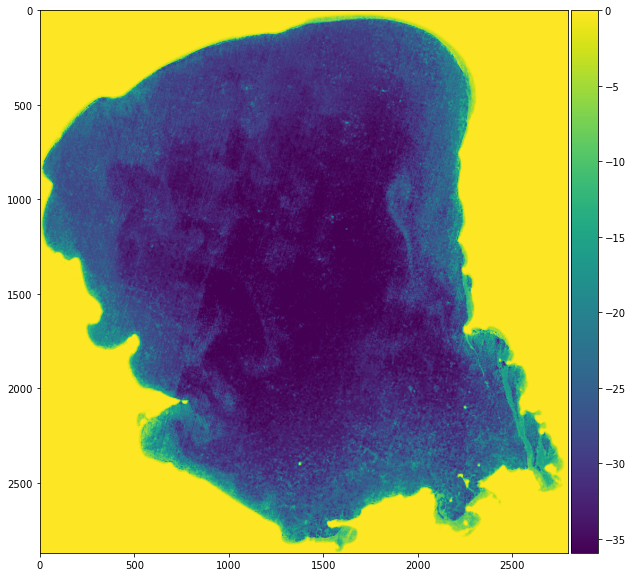

In [30]:
eolx.visualization.plot_ndarray_band(empty_validation_target, cmap='viridis')

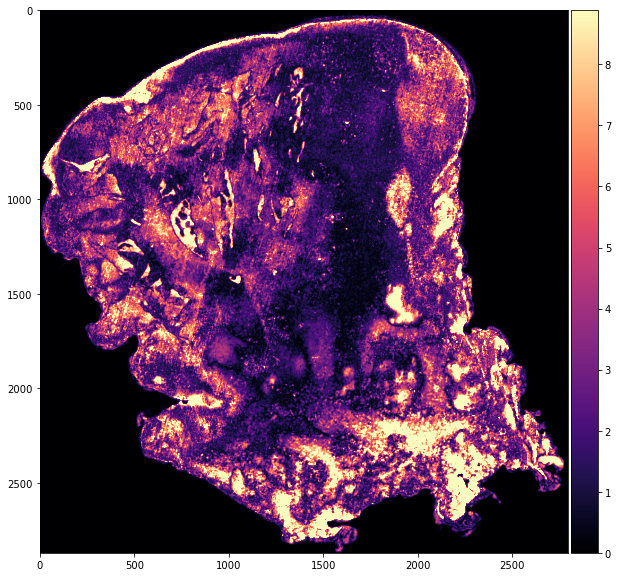

In [31]:
eolx.visualization.plot_ndarray_band(np.abs(empty_validation_target - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]), cmap='magma')

### L2A Testing

In [32]:
all_band_train_index = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], repeats=12, axis=-1)
X = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_train_index == 1], (traincount, 12))
y = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')] == 1]
X.shape, y.shape

((4159120, 12), (4159120,))

In [33]:
model = LGBMRegressor()
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=42)
n_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
np.mean(n_scores), np.std(n_scores)

(-24.980478168837863, 0.022773933190237745)

In [34]:
model = LGBMRegressor()
model.fit(X, y)

LGBMRegressor()

In [35]:
bathy_pixels = np.sum(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1)

all_band_index_complete = np.repeat(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], repeats=12, axis=-1)
X_all = np.reshape(train_test_eop[(FeatureType.DATA, 'L2A_data')][0,:,:,:][all_band_index_complete == 1], (bathy_pixels, 12))

y_hat_all = model.predict(X_all)
empty_validation_target = np.zeros(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')].shape)
empty_validation_target[train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')] == 1] = y_hat_all

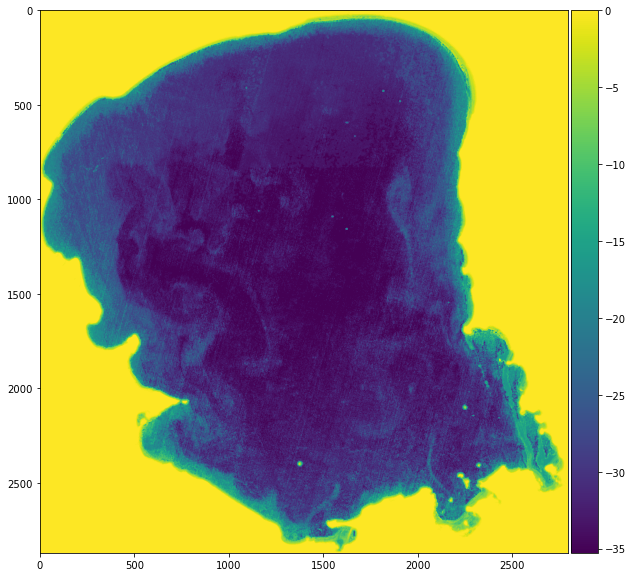

In [36]:
eolx.visualization.plot_ndarray_band(empty_validation_target, cmap='viridis')

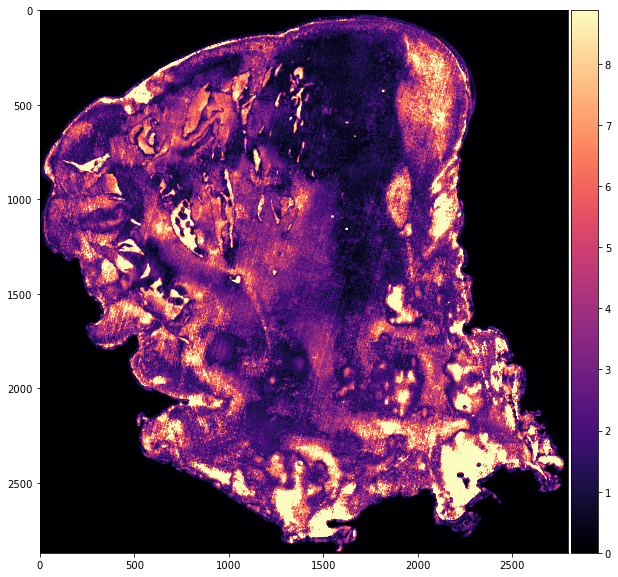

In [37]:
eolx.visualization.plot_ndarray_band(np.abs(empty_validation_target - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]), cmap='magma')

### Validate SAFE archive to EOPatch Against SentinelHub

In [38]:
from eolearn.core import SaveTask, LinearWorkflow
from eolearn.io import SentinelHubInputTask
from sentinelhub.data_collections import DataCollection

roi_bbox = train_test_eop.bbox
time_interval = ("2021-11-23", "2021-11-26")
maxcc = 0.3
resolution = 20
time_difference = datetime.timedelta(hours=2)

input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    bands_feature=(FeatureType.DATA, "L1C_data"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=resolution,
    maxcc=maxcc,
    time_difference=time_difference,
    # config=config,
    max_threads=3,
)

save_task = SaveTask("io_validation_example", overwrite_permission=2, compress_level=1)

workflow_nodes = [input_task, save_task]
workflow = LinearWorkflow(workflow_nodes)

ImportError: cannot import name 'LinearWorkflow' from 'eolearn.core' (C:\Users\gregor\Miniconda3\envs\eo-learn\lib\site-packages\eolearn\core\__init__.py)

In [ ]:
result = workflow.execute({
    input_task: {"bbox": roi_bbox, "time_interval": time_interval},
    save_task: {"eopatch_folder": "../data/eopatches"}
})

result_eopatch = result.eopatch()
result_eopatch

EOPatch(
  data: {
    L1C_data: numpy.ndarray(shape=(1, 1535, 1497, 13), dtype=float32)
  }
  mask: {
    dataMask: numpy.ndarray(shape=(1, 1535, 1497, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.3
    size_x: 1497
    size_y: 1535
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2021, 11, 23, 0, 0), datetime.datetime(2021, 11, 26, 23, 59, 59))
  }
  bbox: BBox(((435481.30653902073, 5105408.316629673), (465412.97317830625, 5136108.2147320695)), crs=CRS('32615'))
  timestamp: [datetime.datetime(2021, 11, 25, 17, 20, 52)]
)

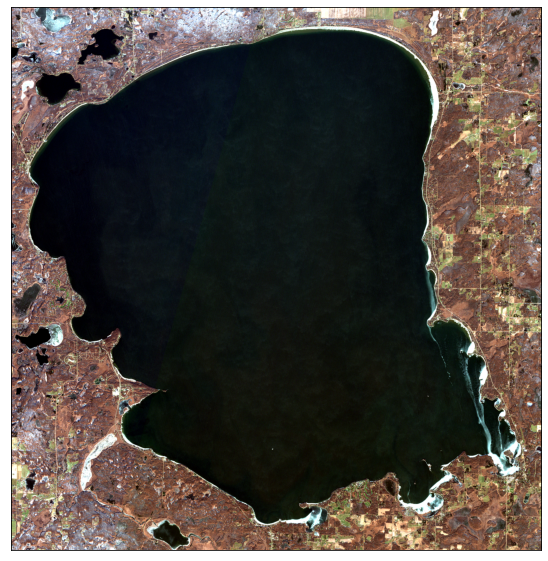

<AxesSubplot:>

In [ ]:
plot_eopatch(result_eopatch, rgb_bands=true_color, feature=(FeatureType.DATA, "L1C_data"))

In [ ]:
result_eopatch.save("../data/eopatches/io_validation_example.eopatch")